#### import Python libraries

In [5]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
import os
import sys

root_dir = ".."
sys.path.append(os.path.join(root_dir, "src"))


In [7]:
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import time
import itertools
from tqdm.autonotebook import tqdm

import torch
from torch.utils.data import DataLoader

from mot.data.data_track import MOT16Sequences
from mot.data.data_obj_detect import MOT16ObjDetect
from mot.models.object_detector import FRCNN_FPN
from mot.tracker.base import Tracker
from mot.utils import (
    plot_sequence,
    evaluate_mot_accums,
    get_mot_accum,
    evaluate_obj_detect,
    obj_detect_transforms,
)

import motmetrics as mm

mm.lap.default_solver = "lap"

import copy


/tmp/ipykernel_19007/3367904656.py:6: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [8]:
seed = 735
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)
torch.backends.cudnn.deterministic = True


# MOT16 dataset

The MOT16 challenge provides 7 train and 7 test video sequences with multiple objects (pedestrians) per frame. It includes many challening scenarios with camera movement, high crowdedness and object occlusions. See the [webpage](https://motchallenge.net/data/MOT16/) for video sequences with ground truth annotation.

The `MOT17Sequences` dataset class provides the possibilty to load single sequences, e.g., `seq_name = 'mot16_02'`, or the entire train/test set, e.g., `seq_name = 'mot16_train'`.


In order to compare the tracking performance of different trackers without the effect of the object detector, the MOTChallenge provides a precomputed set of public object detections. Trackers are then evaluated on their capabilities to form tracks with the provided set. However, we want to allow you to improve on the object detections as well. Therefore, we participate in the MOT16 challenge with private detections.

## Instance segmentations

We provide the instance segmentations for the sequences `02`, `05`, `09` and `11`. These can be used for example to train a method which improves the bounding box position in occluded situations. See the original MOTS [webpage](https://www.vision.rwth-aachen.de/page/mots) for more info.

In [9]:
data_dir = os.path.join(root_dir, "data/MOT16/train")


in MOT16 dataset
sequences ['MOT16-02']
MOT16-02


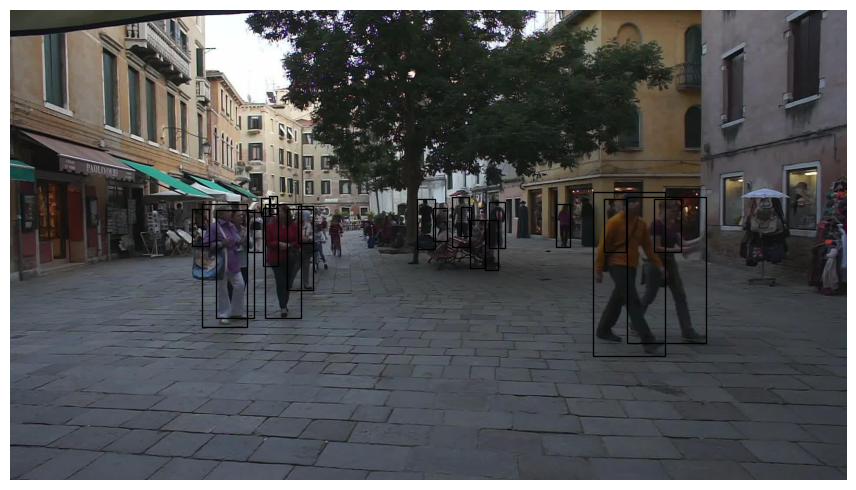

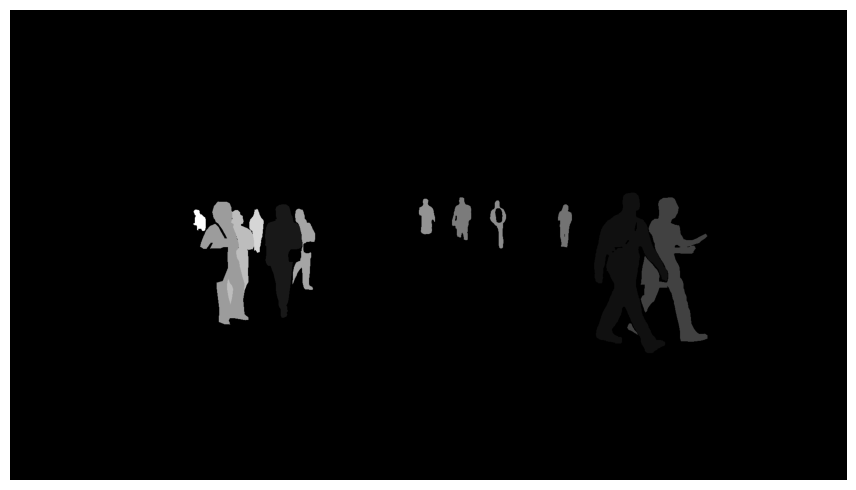

In [10]:
seq_name = "MOT16-02"
data_dir = os.path.join(root_dir, "data/MOT16")
sequences = MOT16Sequences(seq_name, data_dir, load_seg=True)

for seq in sequences:
    print(seq)
    for i, frame in enumerate(seq):
        img = frame["img"]

        dpi = 96
        fig, ax = plt.subplots(1, dpi=dpi)

        img = img.mul(255).permute(1, 2, 0).byte().numpy()
        width, height, _ = img.shape

        ax.imshow(img, cmap="gray")
        fig.set_size_inches(width / dpi, height / dpi)

        if "gt" in frame:
            gt = frame["gt"]
            for gt_id, box in gt.items():
                rect = plt.Rectangle(
                    (box[0], box[1]),
                    box[2] - box[0],
                    box[3] - box[1],
                    fill=False,
                    linewidth=1.0,
                )
                ax.add_patch(rect)

        plt.axis("off")
        plt.show()

        if "seg_img" in frame:
            seg_img = frame["seg_img"]
            fig, ax = plt.subplots(1, dpi=dpi)
            fig.set_size_inches(width / dpi, height / dpi)
            ax.imshow(seg_img, cmap="gray")
            plt.axis("off")
            plt.show()
        break


# Object detector

We provide you with an object detector pretrained on the MOT challenge training set. This detector can be used and improved to generate the framewise detections necessary for the subsequent tracking and data association step.

The object detector is a [Faster R-CNN](https://arxiv.org/abs/1506.01497) with a Resnet50 feature extractor. We trained the native PyTorch implementation of Faster-RCNN. For more information check out the corresponding PyTorch [webpage](https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html).


## Configuration

In [11]:
obj_detect_model_file = os.path.join(root_dir, "models/faster_rcnn_fpn.model")
obj_detect_nms_thresh = 0.3


In [12]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# object detector
obj_detect = FRCNN_FPN(num_classes=2, nms_thresh=obj_detect_nms_thresh)
obj_detect_state_dict = torch.load(
    obj_detect_model_file, map_location=lambda storage, loc: storage
)
obj_detect.load_state_dict(obj_detect_state_dict)
obj_detect.eval()
obj_detect = obj_detect.to(device)


/data/home/m.goldin/anaconda3/envs/tracking/lib/python3.10/site-packages/torchvision/models/_utils.py:135: UserWarning: Using 'backbone_name' and 'weights' as positional parameter(s) is deprecated since 0.13 and will be removed in 0.15. Please use keyword parameter(s) instead.
  warnings.warn(
/data/home/m.goldin/anaconda3/envs/tracking/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [13]:
sorted(os.listdir(os.path.join(root_dir, "data/MOT16/train")))


['.DS_Store',
 'MOT16-02',
 'MOT16-04',
 'MOT16-05',
 'MOT16-09',
 'MOT16-10',
 'MOT16-11',
 'MOT16-13']

In [14]:
dataset_test = MOT16ObjDetect(
    os.path.join(root_dir, "data/MOT16/train"), obj_detect_transforms(train=False)
)


def collate_fn(batch):
    return tuple(zip(*batch))


data_loader_test = DataLoader(
    dataset_test,
    batch_size=1,
    shuffle=True,
    num_workers=4,
    collate_fn=collate_fn,
)

# evaluate_obj_detect(obj_detect, data_loader_test) # <-- takes a while.


If you uncomment und run the following evaluation of the object detection training set, you should obtain the following evaluation result:  
`AP: 0.878304423893276 Prec: 0.9225370296471914 Rec: 0.9166948510117208 TP: 78602.0 FP: 6600.0
`

# Check single seq

In [15]:
data_it = iter(data_loader_test)


In [16]:
index = 100
imgs, targets = next(itertools.islice(data_it, index, None))


In [17]:
print(f"num obj in batch = {len(imgs)}")
print(f"img tensor size = {imgs[0].shape}")


num obj in batch = 1
img tensor size = torch.Size([3, 1080, 1920])


In [18]:
print(f"num obj in targets = {len(targets)}")
print(f"targets keys = {targets[0].keys()}")


num obj in targets = 1
targets keys = dict_keys(['boxes', 'labels', 'image_id', 'area', 'iscrowd', 'visibilities'])


In [20]:
print("targets dict\n", targets)


targets dict
 ({'boxes': tensor([[1155.,  345., 1316.,  773.],
        [1034.,  411., 1158.,  758.],
        [ 521.,  287.,  751.,  866.],
        [ 172.,  282.,  539.,  992.],
        [1610.,  422., 1744.,  647.],
        [1455.,  536., 1519.,  701.],
        [1474.,  425., 1575.,  692.],
        [1694.,  399., 1804.,  637.],
        [ 693.,  268.,  928.,  891.]]), 'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1]), 'image_id': tensor([2462]), 'area': tensor([ 68908.,  43028., 133170., 260570.,  30150.,  10560.,  26967.,  26180.,
        146405.]), 'iscrowd': tensor([0, 0, 0, 0, 0, 0, 0, 0, 0]), 'visibilities': tensor([1.0000, 0.9603, 0.6552, 1.0000, 1.0000, 1.0000, 0.7320, 0.5802, 1.0000])},)


## Eval on single batch

In [21]:
device = list(obj_detect.parameters())[0].device
imgs = [img.to(device) for img in imgs]
obj_detect.eval()
with torch.no_grad():
    preds = obj_detect(imgs)


In [22]:
print("preds dict:\n", preds)


preds dict:
 [{'boxes': tensor([[1613.4077,  424.0216, 1738.0872,  648.7872],
        [1160.3623,  342.9137, 1318.5499,  769.2048],
        [1453.8063,  532.1733, 1519.7140,  698.8230],
        [1693.6230,  400.2251, 1803.9031,  634.7123],
        [1473.1893,  425.0486, 1573.9347,  695.9205],
        [ 696.8867,  271.7057,  923.3065,  864.9677],
        [ 170.9328,  286.8794,  550.9274,  984.5118],
        [1035.1256,  410.0938, 1155.8954,  759.4028],
        [ 508.9305,  281.0883,  744.2401,  859.6183]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.9999],
       device='cuda:0')}]


# Visualize pred

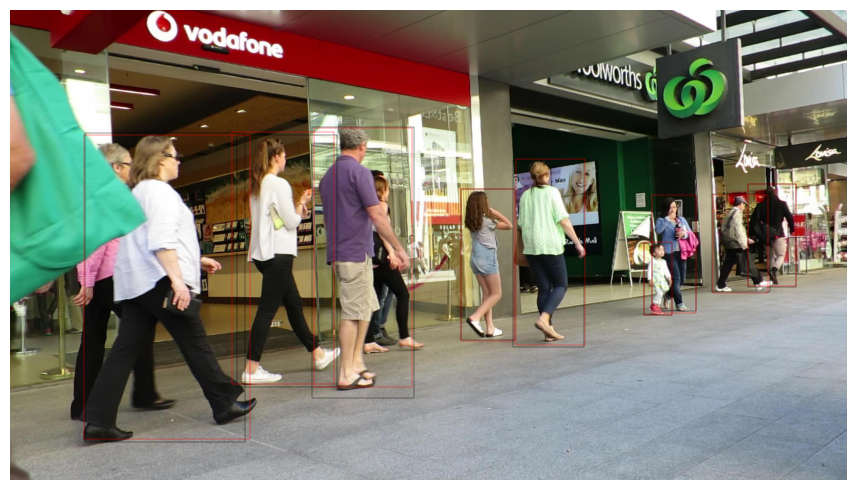

In [20]:
img = imgs[0].cpu()

dpi = 96
fig, ax = plt.subplots(1, dpi=dpi)

img = img.mul(255).permute(1, 2, 0).byte().numpy()
width, height, _ = img.shape

ax.imshow(img, cmap="gray")
fig.set_size_inches(width / dpi, height / dpi)

gt = targets[0]
for box in gt["boxes"]:
    rect = plt.Rectangle(
        (box[0], box[1]),
        box[2] - box[0],
        box[3] - box[1],
        fill=False,
        linewidth=0.3,
        color="black",
    )
    ax.add_patch(rect)

for box in preds[0]["boxes"].cpu().numpy():
    rect = plt.Rectangle(
        (box[0], box[1]),
        box[2] - box[0],
        box[3] - box[1],
        fill=False,
        linewidth=0.3,
        color="red",
    )
    ax.add_patch(rect)

plt.axis("off")
plt.show()


# Change obj_detect_nms_thresh to get more detections

In [23]:
# black - GT, red- predicted, as where are several FN (no detected) pedestrials in  top-left corner
# lets change obj_detect_nms_thresh to add more detections
obj_detect_nms_thresh = 0.8


In [24]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
# object detector
obj_detect = FRCNN_FPN(num_classes=2, nms_thresh=obj_detect_nms_thresh)
obj_detect_state_dict = torch.load(
    obj_detect_model_file, map_location=lambda storage, loc: storage
)
obj_detect.load_state_dict(obj_detect_state_dict)
obj_detect.eval()
obj_detect = obj_detect.to(device)


In [25]:
device = list(obj_detect.parameters())[0].device
imgs = [img.to(device) for img in imgs]
obj_detect.eval()
with torch.no_grad():
    preds = obj_detect(imgs)


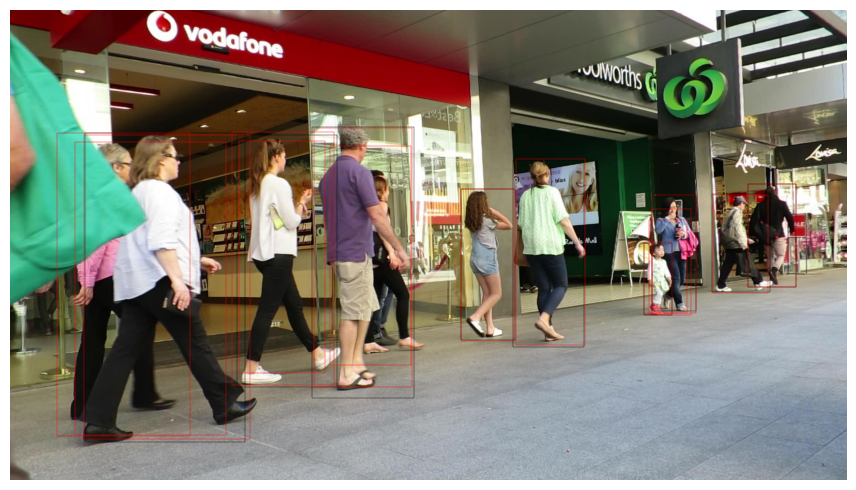

In [26]:
img = imgs[0].cpu()

dpi = 96
fig, ax = plt.subplots(1, dpi=dpi)

img = img.mul(255).permute(1, 2, 0).byte().numpy()
width, height, _ = img.shape

ax.imshow(img, cmap="gray")
fig.set_size_inches(width / dpi, height / dpi)

gt = targets[0]
for box in gt["boxes"]:
    rect = plt.Rectangle(
        (box[0], box[1]),
        box[2] - box[0],
        box[3] - box[1],
        fill=False,
        linewidth=0.3,
        color="black",
    )
    ax.add_patch(rect)

for box in preds[0]["boxes"].cpu().numpy():
    rect = plt.Rectangle(
        (box[0], box[1]),
        box[2] - box[0],
        box[3] - box[1],
        fill=False,
        linewidth=0.3,
        color="red",
    )
    ax.add_patch(rect)

plt.axis("off")
plt.show()


In [27]:
# as a result change obj_detect_nms_thresh 0.3->0.8 add more TP detections, but more FP
